In [17]:
# 导入需要用到的package
import numpy as np
import json
# 读入训练数据
datafile = './work/housing.data'
data = np.fromfile(datafile, sep=' ')

In [24]:
def load_data():
    # 从文件导入数据
    datafile = './work/housing.data'
    data = np.fromfile(datafile, sep=' ')

    # 每条数据包括14项，其中前面13项是影响因素，第14项是相应的房屋价格中位数
    feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', \
                      'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
    feature_num = len(feature_names)

    # 将原始数据进行Reshape，变成[N, 14]这样的形状
    data = data.reshape([data.shape[0] // feature_num, feature_num])

    # 将原数据集拆分成训练集和测试集
    # 这里使用80%的数据做训练，20%的数据做测试
    # 测试集和训练集必须是没有交集的
    ratio = 0.8
    offset = int(data.shape[0] * ratio)
    training_data = data[:offset]

    # 计算训练集的最大值，最小值，平均值
    maximums, minimums, avgs = training_data.max(axis=0), training_data.min(axis=0), \
                                 training_data.sum(axis=0) / training_data.shape[0]
    # 记录数据的归一化参数，在预测时对数据做归一化
    global max_values
    global min_values
    global avg_values
    max_values = maximums
    min_values = minimums
    avg_values = avgs

    # 对数据进行归一化处理
    for i in range(feature_num):
        #print(maximums[i], minimums[i], avgs[i])
        data[:, i] = (data[:, i] - avgs[i]) / (maximums[i] - minimums[i])

    # 训练集和测试集的划分比例
    training_data = data[:offset]
    test_data = data[offset:]
    return training_data, test_data

[ 0.30055004 -0.14232673  0.34131295 -0.08663366  0.13429644 -0.22573461
  0.36634938 -0.2350493   0.74827809  0.65363071  0.23125132 -0.51825133
  0.24075744 -0.1750165 ]
Epoch   0 / iter   0, loss = 3.4996
Epoch   0 / iter  20, loss = 0.2816
Epoch   0 / iter  40, loss = 0.7048
Epoch   1 / iter   0, loss = 0.9865
Epoch   1 / iter  20, loss = 0.0307
Epoch   1 / iter  40, loss = 0.0149
Epoch   2 / iter   0, loss = 0.1088
Epoch   2 / iter  20, loss = 0.2628
Epoch   2 / iter  40, loss = 0.2409
Epoch   3 / iter   0, loss = 0.0763
Epoch   3 / iter  20, loss = 0.0618
Epoch   3 / iter  40, loss = 0.0058
Epoch   4 / iter   0, loss = 0.1007
Epoch   4 / iter  20, loss = 0.3342
Epoch   4 / iter  40, loss = 0.0620
Epoch   5 / iter   0, loss = 0.1001
Epoch   5 / iter  20, loss = 0.0513
Epoch   5 / iter  40, loss = 0.0306
Epoch   6 / iter   0, loss = 0.1403
Epoch   6 / iter  20, loss = 0.0093
Epoch   6 / iter  40, loss = 0.1849
Epoch   7 / iter   0, loss = 0.0835
Epoch   7 / iter  20, loss = 0.1384


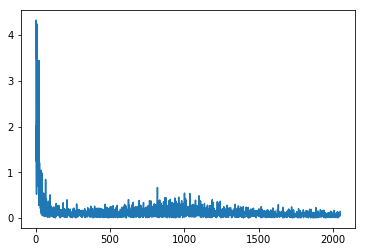

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class Network(object):
    def __init__(self, num_of_weights):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        #np.random.seed(0)
        self.w1 = np.random.randn(num_of_weights, 128)
        self.b1 = 0.
        self.w2 = np.random.randn(128, 1)
        self.b2 = 0. 
        
    def forward(self, x):
        o = np.dot(x, self.w1) + self.b1
        o_sig = sigmoid(o)
        z = np.dot(o_sig, self.w2) + self.b2
        return z, o_sig
    
    def loss(self, z, y):
        error = z - y
        num_samples = error.shape[0]
        cost = error * error
        cost = np.sum(cost) / num_samples
        return cost

    def gradient(self, x, y):
        z, o_sig = self.forward(x)
        N = x.shape[0]
        gradient_w2 = 1. / N * np.sum((z-y)*o_sig, axis=0)
        gradient_w2 = gradient_w2[:, np.newaxis]
        gradient_b2 = 1. / N * np.sum(z-y)

        gradient_w1 = 1. / N * np.sum(np.dot(self.w2.T,np.dot(o_sig.T,(z-y)))*np.dot(x.T,(1-o_sig)), axis=0)
        gradient_w1 = gradient_w1[:, np.newaxis]
        gradient_b1 = 1. / N *  np.sum(np.dot(self.w2.T,np.dot(o_sig.T,(z-y)))*(1-o_sig), axis=0)

        return gradient_w1, gradient_b1, gradient_w2, gradient_b2
    
    def update(self, gradient_w1, gradient_b1, gradient_w2, gradient_b2, eta = 0.01):
        self.w1 = self.w1 - eta * gradient_w1.T
        self.b1 = self.b1 - eta * gradient_b1
        self.w2 = self.w2 - eta * gradient_w2
        self.b2 = self.b2 - eta * gradient_b2
            
                
    def train(self, training_data, num_epochs, batch_size=10, eta=0.01):
        n = len(training_data)
        losses = []
        for epoch_id in range(num_epochs):
            # 在每轮迭代开始之前，将训练数据的顺序随机打乱
            # 然后再按每次取batch_size条数据的方式取出
            np.random.shuffle(training_data)
            # 将训练数据进行拆分，每个mini_batch包含batch_size条的数据
            mini_batches = [training_data[k:k+batch_size] for k in range(0, n, batch_size)]
            for iter_id, mini_batch in enumerate(mini_batches):
                #print(self.w.shape)
                #print(self.b)
                x = mini_batch[:, :-1]
                y = mini_batch[:, -1:]
                a,o_sig = self.forward(x)
                loss = self.loss(a, y)
                gradient_w1, gradient_b1, gradient_w2, gradient_b2 = self.gradient(x, y,)
                self.update(gradient_w1, gradient_b1, gradient_w2, gradient_b2, eta)
                losses.append(loss)
                if iter_id%20 == 0:
                    print('Epoch {:3d} / iter {:3d}, loss = {:.4f}'.
                                    format(epoch_id, iter_id, loss))
        
        return losses

    def predict(self, x):
        a,o_sig = self.forward(x)
        return a


# 获取数据
train_data, test_data = load_data()
print(test_data[:10][-1])

# 创建网络
net = Network(13)
# 启动训练
losses = net.train(train_data, num_epochs=50, batch_size=10, eta=0.01)


# 画出损失函数的变化趋势
plot_x = np.arange(len(losses))
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.savefig('curve.jpg')
plt.show()

In [32]:
def load_one_example():
    # 从上边已加载的测试集中，随机选择一条作为测试数据
    # idx = np.random.randint(0, test_data.shape[0])
    idx = -5
    one_data, label = test_data[idx, :-1], test_data[idx, -1]
    # 修改该条数据shape为[1,13]
    one_data =  one_data.reshape([1,-1])

    return one_data, label


# 参数为数据集的文件地址
one_data, label = load_one_example()
predict = net.predict(one_data)

# 对结果做反归一化处理
predict = predict * (maximums[-1] - minimums[-1]) + avgs[-1]
# 对label数据做反归一化处理
label = label * (maximums[-1] - minimums[-1]) + avgs[-1]

print("Inference result is {}, the corresponding label is {}".format(predict, label))

Inference result is [[22.64035121]], the corresponding label is 22.4
